In [16]:
!pip install --quiet scikit-learn torchsummary

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [18]:
data_path = 'data_crossval'

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

batch_size = 32
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Load the best model
best_model = models.resnet18()
best_model.fc = nn.Linear(best_model.fc.in_features, 2)
best_model.load_state_dict(torch.load('best_transfer_learning_model.pth', map_location=torch.device('cpu')))
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

In [21]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 99.30%
Precision: 0.9950
Recall: 0.9910
F1 Score: 0.9930

Confusion Matrix:
[[995   5]
 [  9 991]]


T-statistic: 1.069083168974288, p-value: 0.2851612711560458
Confusion Matrix:
[[995   5]
 [  9 991]]


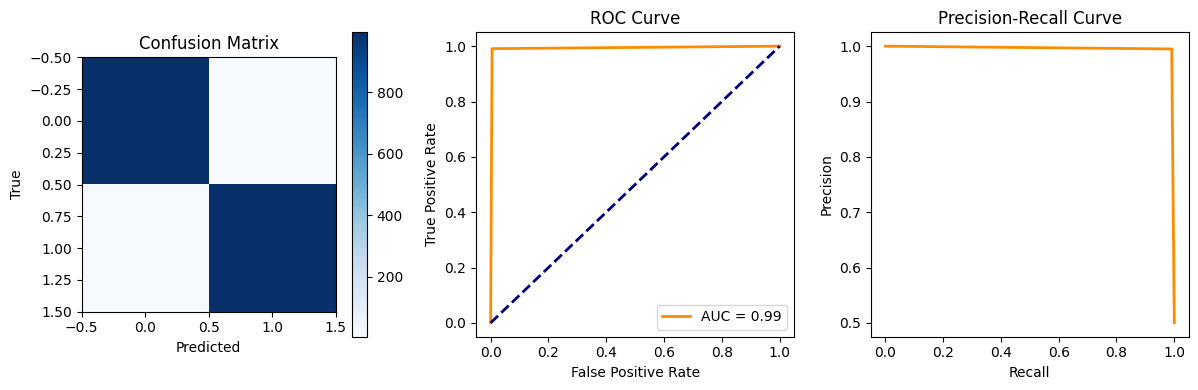

In [22]:
# T-test
t_stat, p_value = ttest_rel(true_labels, predicted_labels)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(conf_matrix, cmap='Blues', interpolation='None')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()